a notebook to test recipe

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from classes.matrix_class import ProteinMatrix
from classes.cluster_class import AllClusters
from classes.degreelist_class import DegreeList

from func_e.FUNC_E import FUNC_E 
import func_e.vocabs.all as vocabs


from recipe_utils import initialize_matrix_clusters_degreelist
from recipe_utils import find_clusters_and_proteins_together
from recipe_utils import print_querylist_of_clusters_to_file
from recipe_utils import get_initialized_fe
from recipe_utils import print_protein_background_to_file


In [2]:
import matplotlib.pyplot as plt
import json


In [3]:
def create_term_mapping_list(go_terms_filepath: str, term_mapping_filepath: str = 'term_mapping.txt'):
    """
    the original file (go_terms_filepath) is in form GOTERM tab PROTEIN, while the term mapping file (term_mapping_filepath) is printed in form PROTEIN tab GOTERM. if a protein has multiple they appear on seperate lines
    """
    with open(term_mapping_filepath, 'w') as file:
        with open(go_terms_filepath, 'r') as go_annotation_file:
            for _ in range(1): # first line of file has column titles, and should be skipped
                next(go_annotation_file)
            for line in go_annotation_file:
                terms = line.split()
                file.write(f"{terms[1]}\t{terms[0]}\n")

In [4]:
dream3_cluster_dict_file = "../../data/results/DREAM-3-cc/d3_5_100.json-cluster.json"
dict_of_clusters = {}
# # convert actual cluster file to a dictionary!!
with open(dream3_cluster_dict_file,"r") as cluster_dict_file:
    dict_of_clusters = json.load(cluster_dict_file)


In [5]:
matrix, clusters, degreelist = initialize_matrix_clusters_degreelist("../../data/networks/DREAM_files/dream_3.txt", "../../data/results/DREAM-3-cc/d3_5_100.json-cluster.json")

In [6]:
genomic_background_filepath = '../../data/testing_data/protein_list.txt'
all_go_terms = vocabs.getTerms(['GO'])
term_mapping_filepath = 'term_mapping.txt'
create_term_mapping_list('../../data/go-results/dream_3_go_results.tsv', term_mapping_filepath)

# METHOD:

In [7]:
# run program using min_components method
qualifying_clusters, qualifying_proteins = find_clusters_and_proteins_together(matrix, clusters, degreelist, cluster_ratio=0, cluster_constant=0,min_components_that_protein_connects=3)

In [8]:
print(qualifying_proteins.keys())

dict_keys([0, 4, 6, 7, 11, 12, 13, 14, 21, 25, 26, 29, 30, 32, 34, 39, 41, 47, 49, 50, 51, 61, 62, 63, 65, 69, 72, 73, 75, 77, 79, 81, 82, 84, 85, 87, 89, 90, 95, 96, 98, 99, 103, 104, 107, 108, 110, 111, 114, 115, 117, 119, 121, 122, 123, 125, 126, 127, 132, 134, 137, 138, 141, 142, 144, 146, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 164, 167, 168, 170, 171, 172, 175, 178, 179, 180, 185, 189, 193, 194, 195])


In [9]:
original_clusters_querylist = 'og_querylist.txt'
updated_clusters_querylist_all_proteins = 'new_querylist_all_proteins.txt'

# original:
print_querylist_of_clusters_to_file(clusters, qualifying_proteins.keys(),original_clusters_querylist)

# clusters with all proteins added:
print_querylist_of_clusters_to_file(clusters, qualifying_proteins.keys(), updated_clusters_querylist_all_proteins, qualifying_proteins)

In [10]:
original_fe = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

original_fe.importFiles({'query': original_clusters_querylist })
original_fe.run(cluster=False)


In [11]:
updated_fe_all_proteins = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

updated_fe_all_proteins.importFiles({'query': updated_clusters_querylist_all_proteins })
updated_fe_all_proteins.run(cluster=False)

In [12]:
# add only 1 protein
one_qualifying_protein = dict()
for key in qualifying_proteins:
    one_qualifying_protein[key] = [qualifying_proteins[key][0]]


updated_clusters_querylist_one_protein = 'new_querylist_one_protein.txt'
print_querylist_of_clusters_to_file(clusters, one_qualifying_protein.keys(), updated_clusters_querylist_one_protein, one_qualifying_protein)

# run functional enrichment for 1 protein added
updated_fe_one_protein = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)
updated_fe_one_protein.importFiles({'query': updated_clusters_querylist_one_protein })
updated_fe_one_protein.run(cluster=False)

In [15]:
# add only (up to) 2 proteins
two_qualifying_proteins = dict()
for key in qualifying_proteins:
    two_qualifying_proteins[key] = qualifying_proteins[key][0:2]

updated_clusters_querylist_two_proteins = 'new_querylist_two_proteins.txt'
print_querylist_of_clusters_to_file(clusters, two_qualifying_proteins.keys(), updated_clusters_querylist_two_proteins, two_qualifying_proteins)

# run functional enrichment for 3 proteins added
updated_fe_two_proteins = get_initialized_fe(genomic_background_filepath, term_mapping_filepath, termlist = all_go_terms)

updated_fe_two_proteins.importFiles({'query': updated_clusters_querylist_two_proteins })

updated_fe_two_proteins.run(cluster=False)

In [13]:
# add only (up to) 3 proteins
three_qualifying_proteins = dict()
for key in qualifying_proteins:
    three_qualifying_proteins[key] = qualifying_proteins[key][0:3]

updated_clusters_querylist_three_proteins = 'new_querylist_three_proteins.txt'
print_querylist_of_clusters_to_file(clusters, three_qualifying_proteins.keys(), updated_clusters_querylist_three_proteins, three_qualifying_proteins)

# run functional enrichment for 3 proteins added
updated_fe_three_proteins = get_initialized_fe(genomic_background_filepath, 

term_mapping_filepath, termlist = all_go_terms)
updated_fe_three_proteins.importFiles({'query': updated_clusters_querylist_three_proteins })

updated_fe_three_proteins.run(cluster=False)

In [16]:
print(f"number of clusters that were updated with 1,2,3, all proteins: {len(qualifying_proteins.keys())}\n")

# clusters that are functionall enriched
print(f"number of functionally enriched clusters (modules) out of {len(qualifying_proteins.keys())} original clusters: {original_fe.enrichment['Module'].nunique()}")

print(f"number of functionally enriched clusters after addition of 1 protein: {updated_fe_one_protein.enrichment['Module'].nunique()}")

print(f"number of functionally enriched clusters after addition of 2 proteins: {updated_fe_two_proteins.enrichment['Module'].nunique()}")

print(f"number of functionally enriched clusters after addition of 3 proteins: {updated_fe_three_proteins.enrichment['Module'].nunique()}")
# TODO for above and below figure out avg number of proteins added
print(f"number of functionally enriched clusters after addition of all proteins: {updated_fe_all_proteins.enrichment['Module'].nunique()}")



print(f"")



# significant P-values!!!
print(f"number of significant pvals in original clusters before updating: {original_fe.enrichment['Fishers_pvalue'].count()}")

print(f"number of significant pvals in clusters with 1 protein added: {updated_fe_one_protein.enrichment['Fishers_pvalue'].count()}")

print(f"number of significant pvals in clusters with up to 2 proteins added: {updated_fe_two_proteins.enrichment['Fishers_pvalue'].count()}")

print(f"number of significant pvals in clusters with up to 3 proteins added: {updated_fe_three_proteins.enrichment['Fishers_pvalue'].count()}")
# TODO for above and below figure out avg number of proteins added
print(f"number of significant pvals in clusters with all proteins added: {updated_fe_all_proteins.enrichment['Fishers_pvalue'].count()}")



number of clusters that were updated with 1,2,3, all proteins: 94

number of functionally enriched clusters (modules) out of 94 original clusters: 84
number of functionally enriched clusters after addition of 1 protein: 90
number of functionally enriched clusters after addition of 2 proteins: 91
number of functionally enriched clusters after addition of 3 proteins: 91
number of functionally enriched clusters after addition of all proteins: 91

number of significant pvals in original clusters before updating: 244
number of significant pvals in clusters with 1 protein added: 293
number of significant pvals in clusters with up to 2 proteins added: 314
number of significant pvals in clusters with up to 3 proteins added: 339
number of significant pvals in clusters with all proteins added: 502


In [17]:
# find the avg number of proteins added for 3 and all proteins
sum_all = 0
for key in qualifying_proteins.keys():
    sum_all += len(qualifying_proteins[key])


sum_three = 0
for key in three_qualifying_proteins.keys():
    sum_three += len(three_qualifying_proteins[key])

sum_two = 0
for key in two_qualifying_proteins.keys():
    sum_two += len(two_qualifying_proteins[key])

print(f"avg number of two proteins: {sum_two/len(two_qualifying_proteins)}\navg number of three proteins: {sum_three/len(three_qualifying_proteins)}\navg number of all proteins: {sum_all/len(qualifying_proteins)}")

avg number of two proteins: 1.6808510638297873
avg number of three proteins: 2.1914893617021276
avg number of all proteins: 7.75531914893617


In [ ]:
# TODO find which GO terms are new and which are old

/var/folders/hk/q40rrztn3glcl0jvwjcpzyth0000gn/T/ipykernel_17887/3464677039.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_values, fontsize=12)


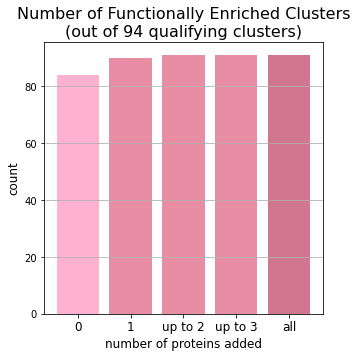

In [18]:
# create clusters graph
fig, ax = plt.subplots()

x_values = ["0", "1", "up to 2","up to 3", "all"]
counts = [original_fe.enrichment['Module'].nunique(), updated_fe_one_protein.enrichment['Module'].nunique(), updated_fe_two_proteins.enrichment['Module'].nunique(), updated_fe_three_proteins.enrichment['Module'].nunique(), updated_fe_all_proteins.enrichment['Module'].nunique()]

ax.bar(x_values, counts, color=['xkcd:powder pink', 'xkcd:pig pink', 'xkcd:pig pink', 'xkcd:pig pink', 'xkcd:muted pink'])

ax.set_xticklabels(x_values, fontsize=12)

ax.set_title(f"Number of Functionally Enriched Clusters\n(out of {len(qualifying_proteins.keys())} qualifying clusters)", fontsize=16)
ax.set_ylabel('count', fontsize=12)

ax.set_xlabel('number of proteins added', fontsize=12)

ax.grid(axis='y')

fig.set_size_inches(5,5)
plt.show()


/var/folders/hk/q40rrztn3glcl0jvwjcpzyth0000gn/T/ipykernel_17887/3688101204.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_values, fontsize=12)


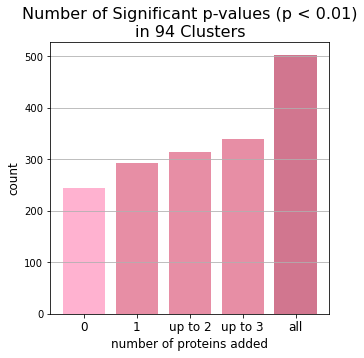

In [19]:
# create p-val graph
fig, ax = plt.subplots()

x_values = ["0", "1", "up to 2", "up to 3", "all"]
counts = [original_fe.enrichment['Fishers_pvalue'].count(), updated_fe_one_protein.enrichment['Fishers_pvalue'].count(), updated_fe_two_proteins.enrichment['Fishers_pvalue'].count(), updated_fe_three_proteins.enrichment['Fishers_pvalue'].count(), updated_fe_all_proteins.enrichment['Fishers_pvalue'].count()]

ax.bar(x_values, counts, color=['xkcd:powder pink', 'xkcd:pig pink', 'xkcd:pig pink', 'xkcd:pig pink', 'xkcd:muted pink'])

ax.set_xticklabels(x_values, fontsize=12)

ax.set_title(f"Number of Significant p-values (p < 0.01)\nin {len(qualifying_proteins.keys())} Clusters", fontsize=16)

# TODO: do i want to say number of significant p-values, or do i want to say number of Go-Terms / labels etc

ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('number of proteins added', fontsize=12)

ax.grid(axis='y')

fig.set_size_inches(5,5)
plt.show()



In [31]:
# TODO: now want to see which GO terms are functionally enriched

original_enriched_terms = original_fe.enrichment['Term']
enriched_terms_one_protein = updated_fe_one_protein.enrichment['Term']
enriched_terms_two_proteins = updated_fe_two_proteins.enrichment['Term']
enriched_terms_three_proteins = updated_fe_three_proteins.enrichment['Term']
enriched_terms_all_proteins = updated_fe_all_proteins.enrichment['Term']

In [37]:
original_terms_vs_1p = (set(original_enriched_terms) - set(enriched_terms_one_protein))
original_terms_vs_2p = (set(original_enriched_terms) - set(enriched_terms_two_proteins))
original_terms_vs_3p = (set(original_enriched_terms) - set(enriched_terms_three_proteins))
original_terms_vs_allp = (set(original_enriched_terms) - set(enriched_terms_all_proteins))

new_terms_1p = (set(enriched_terms_one_protein) - set(original_enriched_terms))
new_terms_2p = (set(enriched_terms_two_proteins) - set(original_enriched_terms))
new_terms_3p = (set(enriched_terms_three_proteins) - set(original_enriched_terms))
new_terms_allp = (set(enriched_terms_all_proteins) - set(original_enriched_terms))


print(f"{original_terms_vs_1p}")
print(f"{original_terms_vs_2p}")
print(f"{original_terms_vs_3p}")
print(f"{original_terms_vs_allp}")

print(f"{new_terms_1p}")
print(f"{new_terms_2p}")
print(f"{new_terms_3p}")
print(f"{new_terms_allp}")

{'GO:0010165', 'GO:0051019', 'GO:0030041', 'GO:0002755', 'GO:0048015', 'GO:0048010', 'GO:0055037', 'GO:0001774', 'GO:2001237', 'GO:0051281', 'GO:0005882', 'GO:0043565', 'GO:0050830', 'GO:0005604', 'GO:0010951', 'GO:0030279', 'GO:0043280', 'GO:0046718', 'GO:0008157', 'GO:0035666', 'GO:0070979', 'GO:0032728', 'GO:0008277', 'GO:0048011', 'GO:2000463', 'GO:0031398', 'GO:0050767', 'GO:0046854', 'GO:2000310', 'GO:0007346'}
{'GO:0007026', 'GO:0010165', 'GO:0051019', 'GO:0030041', 'GO:0045765', 'GO:2000406', 'GO:0045944', 'GO:0043537', 'GO:0002755', 'GO:0031573', 'GO:0060444', 'GO:0048015', 'GO:0035307', 'GO:0055037', 'GO:0001774', 'GO:2001237', 'GO:0007601', 'GO:0032515', 'GO:0005819', 'GO:2001235', 'GO:0051281', 'GO:0005882', 'GO:0050830', 'GO:0043410', 'GO:0043276', 'GO:0010951', 'GO:0072332', 'GO:0005604', 'GO:0030279', 'GO:0046718', 'GO:0002479', 'GO:0035666', 'GO:0043280', 'GO:0008157', 'GO:0030667', 'GO:0070979', 'GO:0016567', 'GO:0032728', 'GO:0008277', 'GO:0048011', 'GO:2000463', 'GO:

In [109]:
# construct a go term vs definition dict
go_to_def_dict = dict()
with open("data/GO.terms.tsv", 'r') as go_term_to_def_file:
    for line in go_term_to_def_file:
        arr = line.split()
        string = ""
        for i in arr[2:]:
            string += i
            string += " "
        go_to_def_dict[arr[1]] = string



for term in new_terms_allp:
    print(go_to_def_dict.get(term))

positive regulation of telomere maintenance via telomerase 
positive regulation of smooth muscle cell proliferation 
dendrite cytoplasm 
Fc-epsilon receptor signaling pathway 
positive regulation of I-kappaB kinase/NF-kappaB signaling 
negative regulation of proteolysis 
protein phosphorylation 
axon extension 
peptidyl-tyrosine phosphorylation 
cellular response to peptide hormone stimulus 
positive regulation of erythrocyte differentiation 
JNK cascade 
regulation of cellular response to heat 
positive regulation of glucose import 
positive regulation of intrinsic apoptotic signaling pathway 
DNA replication 
mitotic G2 DNA damage checkpoint signaling 
activation of GTPase activity 
positive regulation of epithelial cell migration 
regulation of translation 
positive regulation of T cell differentiation 
interleukin-2-mediated signaling pathway 
cellular response to amyloid-beta 
non-membrane spanning protein tyrosine kinase activity 
thymus development 
cellular response to reactive

In [74]:
# construct a go term vs label dict. 
go_to_label_dict = dict()


with open("../../data/go-results/dream_3_go_results.tsv", "r") as file:
    for line in file: 
        arr = line.split()
        go_to_label_dict[arr[0]] = arr[2]



In [75]:
# count number of terms of each type
bp_counter_1p = 0
cc_counter_1p = 0
mf_counter_1p = 0
for term in new_terms_1p:
    if go_to_label_dict.get(term) == "biological_process":
        bp_counter_1p += 1
    elif go_to_label_dict.get(term) == "cellular_component":
        cc_counter_1p += 1
    elif go_to_label_dict.get(term) == "molecular_function":
        mf_counter_1p += 1


bp_counter_allp = 0
cc_counter_allp = 0
mf_counter_allp = 0
for term in new_terms_allp:
    if go_to_label_dict.get(term) == "biological_process":
        bp_counter_allp += 1
    elif go_to_label_dict.get(term) == "cellular_component":
        cc_counter_allp += 1
    elif go_to_label_dict.get(term) == "molecular_function":
        mf_counter_allp += 1


/var/folders/hk/q40rrztn3glcl0jvwjcpzyth0000gn/T/ipykernel_17887/257497102.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_values, fontsize=12)


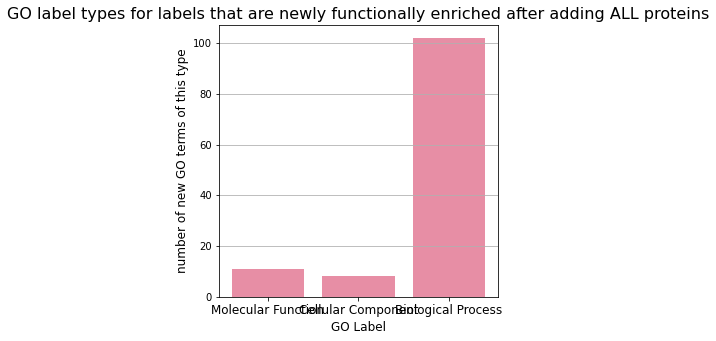

In [77]:
# create graph to compare coutns of each type (all proteins)
fig, ax = plt.subplots()

x_values = ["Molecular Function", "Cellular Component", "Biological Process"]
counts = [mf_counter_allp, cc_counter_allp, bp_counter_allp]

ax.bar(x_values, counts, color=['xkcd:pig pink', 'xkcd:pig pink', 'xkcd:pig pink'])

ax.set_xticklabels(x_values, fontsize=12)

ax.set_title(f"GO label types for labels that are newly functionally enriched after adding ALL proteins", fontsize=16)


ax.set_ylabel('number of new GO terms of this type', fontsize=12)
ax.set_xlabel('GO Label', fontsize=12)

ax.grid(axis='y')

fig.set_size_inches(5,5)
plt.show()



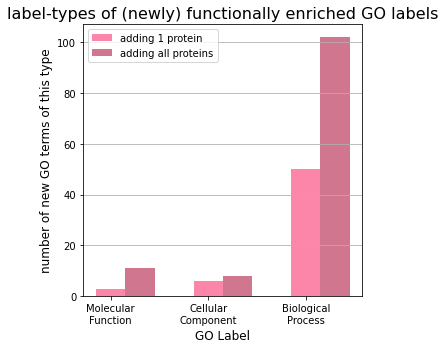

In [107]:
# create graph to compare coutns of each label type (one and all proteins)
fig, ax = plt.subplots()

x_values = ["Molecular\nFunction", "Cellular\nComponent", "Biological\nProcess"]
counts_1p = [mf_counter_1p, cc_counter_1p, bp_counter_1p]
counts_allp = [mf_counter_allp, cc_counter_allp, bp_counter_allp]



width = .3
ax.bar(x_values, counts_1p, width=width, color="xkcd:pinky")
ax.bar(np.arange(len(counts_allp))+ width, counts_allp, width=width, color="xkcd:muted pink")

# ax.set_xticklabels(x_values, fontsize=12)

ax.set_title(f"label-types of (newly) functionally enriched GO labels", fontsize=16)


ax.set_ylabel('number of new GO terms of this type', fontsize=12)
ax.set_xlabel('GO Label', fontsize=12)

ax.grid(axis='y')
ax.legend(["adding 1 protein", "adding all proteins"], loc=2)

fig.set_size_inches(5,5)
plt.show()


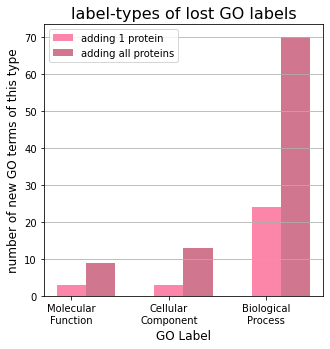

In [108]:
# create graph to compare coutns of each label type ythat was lost (one and all proteins)

original_terms_vs_1p
original_terms_vs_allp

# count number of terms of each type
bp_counter_1p = 0
cc_counter_1p = 0
mf_counter_1p = 0
for term in original_terms_vs_1p:
    if go_to_label_dict.get(term) == "biological_process":
        bp_counter_1p += 1
    elif go_to_label_dict.get(term) == "cellular_component":
        cc_counter_1p += 1
    elif go_to_label_dict.get(term) == "molecular_function":
        mf_counter_1p += 1


bp_counter_allp = 0
cc_counter_allp = 0
mf_counter_allp = 0
for term in original_terms_vs_allp:
    if go_to_label_dict.get(term) == "biological_process":
        bp_counter_allp += 1
    elif go_to_label_dict.get(term) == "cellular_component":
        cc_counter_allp += 1
    elif go_to_label_dict.get(term) == "molecular_function":
        mf_counter_allp += 1


# plot!
fig, ax = plt.subplots()

x_values = ["Molecular\nFunction", "Cellular\nComponent", "Biological\nProcess"]
counts_1p = [mf_counter_1p, cc_counter_1p, bp_counter_1p]
counts_allp = [mf_counter_allp, cc_counter_allp, bp_counter_allp]



width = .3
ax.bar(x_values, counts_1p, width=width, color="xkcd:pinky")
ax.bar(np.arange(len(counts_allp))+ width, counts_allp, width=width, color="xkcd:muted pink")

# ax.set_xticklabels(x_values, fontsize=12)

ax.set_title(f"label-types of lost GO labels", fontsize=16)


ax.set_ylabel('number of new GO terms of this type', fontsize=12)
ax.set_xlabel('GO Label', fontsize=12)

ax.grid(axis='y')
ax.legend(["adding 1 protein", "adding all proteins"], loc=2)

fig.set_size_inches(5,5)
plt.show()


In [115]:
# METHOD ___ STATS:

# avg cluster size of modified cluster (compared to average cluster size)
running_sum = 0
count = 0
for key in clusters.get_all_clusters():
    running_sum += len(clusters.get_cluster_proteins(key))
    count += 1
print(f"the average cluster size is {running_sum/count}")

running_sum = 0
count = 0
for key in qualifying_proteins.keys():
    running_sum += len(clusters.get_cluster_proteins(key))
    count += 1
print(f"the average modified cluster size is {running_sum/count}")


# find the number of proteins added
sum_all = 0
for key in qualifying_proteins.keys():
    sum_all += len(qualifying_proteins[key])


sum_three = 0
for key in three_qualifying_proteins.keys():
    sum_three += len(three_qualifying_proteins[key])

sum_two = 0
for key in two_qualifying_proteins.keys():
    sum_two += len(two_qualifying_proteins[key])

print(f"avg number of two proteins: {sum_two/len(two_qualifying_proteins)}\navg number of three proteins: {sum_three/len(three_qualifying_proteins)}\navg number of all proteins: {sum_all/len(qualifying_proteins)}")



the average cluster size is 23.542713567839197
the average modified cluster size is 37.244680851063826
avg number of two proteins: 1.6808510638297873
avg number of three proteins: 2.1914893617021276
avg number of all proteins: 7.75531914893617


In [ ]:
# TODO: also want to check out on a cluster vs cluster basis